# Basic compute

__resources, pipelines, shaders, descriptor sets, command buffer managers__

Vulky wraps objects of vulkan API in a simpler way. Nevertheless, some objects are a collection of different objects in vulkan. That is the case of a Pipeline. In vulky a ```Pipeline``` object encapsulates work with shaders (VkShaderModule), layouts, bindings, framebuffers, render passes, descriptors.
In this notebook we exemplify the use of vulky to generate the classic Mandelbrot set and introduce the concepts of ```Pipeline```, ```CommandManager``` and some resources.

In [1]:
import vulky as vk
vk.create_device(debug=True)  # good to devise errors not handled by vulky and fallback on vulkan.

[INFO] Vulkan Instance created...
[INFO] Debug instance created...
[INFO] Available devices: 1
[INFO] Selected device: NVIDIA GeForce RTX 2080 Ti

[INFO] Selected device index: 0

[INFO] 5 available queue family
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Librar

Vulky represents resources and their views with the same object. Internally, the memory shared by different aliases are managed, but resources use for bindings, copies and other operations have the 'view' (or slice) intrinsic. Resources represents a hierarchy composed of:
- ```Buffer```: a general use raw buffer. Buffers can be sliced with offset and size.
- ```StructuredBuffer```: a buffer that can be accessed as an array of structures.
- ```ObjectBuffer```: a permanent mapped buffer that can accessed with a simple dot notation.
- ```Image```: a 1D, 2D or 3D image that can be used to store texels, sample or attach to a framebuffer as render target or depth buffer. Images are compound by different subresources for layers and mips.
- ```Sampler```: a description of how texels are sampled from an image.

In this example we will create an image to serve as render target and an object buffer (uniform buffer) to specify the properties of the fractal generator. It is a common pattern in vulky declare named fields with kwargs. Notice how the layout declaration is filled using a notation ```field_name=field_type```.

In [2]:
SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512

render_target = vk.image_2D(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    mips=1,  # Important to make the image single resource
    usage=vk.ImageUsage.STORAGE,
    memory=vk.MemoryLocation.GPU
)

parameters_buffer = vk.object_buffer(
    layout=vk.Layout.from_structure(vk.LayoutAlignment.STD430,
        C=vk.vec2,
        W=float,
    ),
    memory=vk.MemoryLocation.GPU
)

Now, let's define the compute shader that will generate the fractal.

In [3]:
compute_shader_code = """
#version 460

#extension GL_EXT_scalar_block_layout: require

layout (local_size_x = 32, local_size_y = 32, local_size_z = 1) in;

layout(binding = 0, rgba32f) uniform image2D render_target;

layout(binding = 1, std430) uniform Parameters {
    vec2 C;
    float W;
};

vec4 get_color(float m)
{
    m = min(m, 100.0);
    float s = 2*(1.0 / (1 + exp(-m)) - 0.5);
    // return vec4(1 - s, 1.0-s*s, mod(s+0.5, 1.0), 1.0);
    return vec4(1 - s*s, 1 - s, mod(s*s + 0.5, 1.0), 1.0);
}

void main()
{
    ivec3 thread_id = ivec3(gl_GlobalInvocationID);
    ivec2 dim = imageSize(render_target);
    vec2 c = C + W * vec2((thread_id.x + 0.5) / dim.x, (thread_id.y + 0.5) / dim.y) - W/2.0;
    vec2 Z = vec2(0., 0.);
    for (int i=0; i<256; i++)
        Z = vec2(Z.x*Z.x - Z.y*Z.y, 2*Z.x*Z.y) + c;
    float m = sqrt(dot(Z, Z));

    imageStore(render_target, thread_id.xy, get_color(m));    
}
    """

Notice in the code, the shader requires a pipeline that sets a texture and a uniform buffer with std430 layout. In vulkan there are several object that need to be combined to manage such setup, in vulky is simplified under the object ```Pipeline```. Pipelines conforms a hierarchy of valid types of points.

```Pipeline```: Object capable of setup shader modules, resource bindings, create compatible descriptor collections.

```ComputePipeline```: Valid pipeline for Compute command buffer managers.

```GraphicsPipeline```: Valid pipeline for Graphics command buffer managers. Extends a Pipeline to allow to declare attachments, vertex_binding and vertex declarations.   

```RaytracingPipeline```: Valid pipeline for Raytracing command buffer manager. Extends a Pipeline to allow shader group creations.

In [4]:
pipeline = vk.pipeline_compute()
pipeline.layout(set=0, binding=0, render_target=vk.DescriptorType.STORAGE_IMAGE)
pipeline.layout(set=0, binding=1, parameters_buffer=vk.DescriptorType.UNIFORM_BUFFER)
pipeline.load_shader_from_source(compute_shader_code)
pipeline.close()

[INFO] Compiled code for comp


The method ```layout``` is used to speficify each resource that forms part of the pipeline bindings. Notice the use of a single kwarg to refer to a named resource binding declaration. Later that name will be used for the real binding when descriptor sets are created. The pipeline is considered open for setup after the creation and until closed. After this operation, the pipeline can be used to create descriptor sets and bind in the command buffer.

In [5]:
global_bindings = pipeline.create_descriptor_set_collection(set=0, count=1)

Descriptor sets are created in collections (that potentially might be just 1). This is helpful to create different descriptor sets that can be updated while others are in use (e.g. triple-buffering). Or different instances of the same descriptor set to represent different objects (local transforms or properties). In this case we are creating a single global binding set. We use the same reference-name used in the ```layout``` method to bind the resource. The parameter ```set``` refers to the set is being created and ```count``` specifies the number of compatible copies of that descriptor set.

In [6]:
global_bindings[0].update(
    render_target=render_target,
    parameters_buffer=parameters_buffer
)

The descriptor update here takes place in this specific moment. Is equivalent to write descriptors in vulkan. Problems writing descriptor sets being used by the gpu are not controlled by vulky and will face vulkan check.

The parameters in ```parameters_buffer``` should be updated before submission. Using an object buffer in a context allows to work with an accessor that provides a natural field access via dot notation. 

In [7]:
with parameters_buffer as b:
    b.C = vk.vec2(-.748, .1)
    b.W = 0.01

Now we have everything we need to execute the fractal generation on the GPU.
First, create a manager object to command compute actions with ```compute_manager```. This object used in a context will populate the commands in the variable and will submit automatically at the exit.

In [8]:
with vk.compute_manager() as man:
    man.set_pipeline(pipeline)
    man.bind(global_bindings[0])
    man.dispatch_threads_2D(render_target.width, render_target.height)

With a command buffer manager (```man```) the first action will be set the pipeline. Then we bind the descriptor set (```global_bindings[0]```) and finally, we ask the GPU to dispatch a thread for every pixel of the render target. The method ```dispatch_threads_X``` will dispatch sufficient groups to cover the required threads. In the case of 2D grids, the threads are split by default in groups of (32,32,1) but other group size can be specified. You can use ```dispatch_groups``` instead.

In this point, the submission and execution on the GPU has finalized because the implicit submission when a command manager is used in a context waits for finishing the GPU execution. Let's copy the image to a staging tensor to visualize. Vulky is well integrated with Pytorch, and an efficient copy from vulkan resource to a tensor is possible.

In [9]:
staging = vk.tensor(render_target.height, render_target.width, 4)
render_target.save(staging)

Notice that the tensor created may have any shape, but the final size must be compatible with the image is being saved. There is no blit operation with ```save```, although blit operations are also supported. Now, we will view the image with matplotlib.

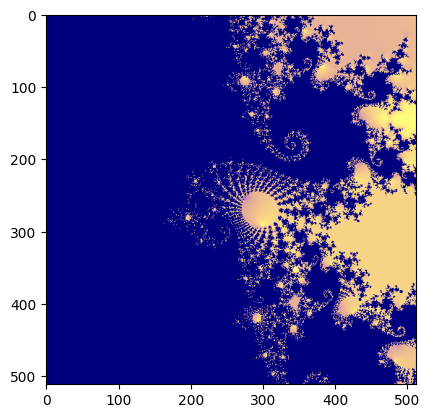

In [10]:
import matplotlib.pyplot as plt
plt.imshow(staging.cpu())
plt.show()

Let's create a simple animation with this:

In [11]:
video_data = vk.tensor(100, SCREEN_HEIGHT, SCREEN_WIDTH, 3)  # 100 frames

man = vk.compute_manager()
man.set_pipeline(pipeline)
man.bind(global_bindings[0])
man.dispatch_threads_2D(render_target.width, render_target.height)
man.freeze()  # can be re-submitted several times

for i in range(len(video_data)):
    # update buffer
    with parameters_buffer as b:
        b.C = vk.vec2(-.74942, .07195)
        b.W = 2.0 * (0.9 ** (100 * i / len(video_data)))
    # re-submit commands to gpu
    vk.submit(man)  # by default will wait until finishes
    render_target.save(staging)
    video_data[i] = staging[...,:3]  # copy current frame to video (only RGB)
    
vk.save_video(video_data, 'mandelbrot.webp', 10, stream_loop='-1')

In [12]:
import IPython.display as display
display.HTML("""
<img src='mandelbrot.webp'/>
""")

In [13]:
# del staging
# vk.quit()